# RNN: Прогнозирование следующей буквы текста


Пример прогнозирования очередной буквы текста при помощи рекуррентной нейронной сети.


Описание: <a href="http://qudata.com/ml/ru/NN_RNN_Torch.html">NN_RNN_Torch.html</a>,

# Библиотеки

In [1]:
import re, zipfile, numpy as np, time
import matplotlib.pyplot as plt
from   time import perf_counter as tm                  # таймер sec

import torch
import torch.nn as nn

# Загружаем текст

Возьмём фиксированным  алфавит `CHARS` (русский язык) в нижнем регистре, включив в него конец строки `\n` (для стихов):

In [2]:
CHARS  = " .?,абвгдежзийклмнопрстуфхцчшщъыьэюя\n"        # фиксированный алфавит 
charID = { c:i for i,c in enumerate(CHARS) }             # буква в номер

def preprocess(txt):
    """ Буквы не из алфавита заменяем пробелами """
    txt = txt.lower().replace('ё','e').replace('!','.').replace(';',',')
    txt = ''.join( [c if c in CHARS else ' ' for c in txt] )    
    txt = re.sub(' +', ' ', txt)
    txt = txt.replace(' ,', ',').replace(' .', '.').replace(' ?', '?')
    return  re.sub('\n\s+', '\n', txt)
    
def load_Zip(fname = "data/books.zip"):
    """ Загрузить в строку содержмое всех файлов из zip-архива, проведя их препроцессинг """
    txt = ""
    with zipfile.ZipFile(fname) as myzip:
        for fname in myzip.namelist():
            print(fname, end=": ")
            with myzip.open(fname) as myfile:
                st = preprocess ( myfile.read().decode("utf-8") )     
                chars, words = len(st), len(st.split())
                print(chars, " chars, ",  words, "words", f"{chars/words:.2f} ch/w")  
                txt += " " + st
    return txt
    
#text = load_Zip("saltan.zip")        
text = load_Zip("books.zip")        
        
print(f"chars: {len(CHARS)}, text length: {len(text)} chars")            
print(f"beg:|{text[:100]}|")        
print(f"end:|{text[-100:]}|")    

Akunin_Priklyucheniya-Erasta-Fandorina_1_Azazel.txt: 360639  chars,  53892 words 6.69 ch/w
Akunin_Provincialnyy-detektiv_1_Pelagiya-i-belyy-buldog.txt: 453786  chars,  68069 words 6.67 ch/w
Akunin_Zhanry_2_Shpionskiy-roman.txt: 419509  chars,  63554 words 6.60 ch/w
Strugackiy_Maksim-Kammerer_1_Obitaemyy-ostrov.txt: 620899  chars,  96243 words 6.45 ch/w
Strugackiy_Maksim-Kammerer_2_Zhuk-v-muraveynike.txt: 345307  chars,  53396 words 6.47 ch/w
Strugackiy_Maksim-Kammerer_3_Volny-gasyat-veter.txt: 272213  chars,  41175 words 6.61 ch/w
Strugackiy_Ponedelnik-nachinaetsya-v-subbotu.txt: 397145  chars,  60050 words 6.61 ch/w
Strugackiy_Ulitka-na-sklone.txt: 374205  chars,  60778 words 6.16 ch/w
Tolstoy_Voyna-i-mir-Tom-1.txt: 668005  chars,  104576 words 6.39 ch/w
Tolstoy_Voyna-i-mir-Tom-2.txt: 726154  chars,  116996 words 6.21 ch/w
Tolstoy_Voyna-i-mir-Tom-3.txt: 814906  chars,  127130 words 6.41 ch/w
Tolstoy_Voyna-i-mir-Tom-4.txt: 674924  chars,  104825 words 6.44 ch/w
Vasilev_Akula-pera-v-Mir

# Параметры

Выход RNN сети должен предсказывать вход, сдвинутый на один символ.

По первым `LEN - NUM` ячейкам сеть будет накапливать скрытое состояние (историю). Ошибки же предсказания будут вычисляться только по последним `NUM` ячейкам. Использование значений `NUM > 1` целесообразно для уменьшения затухания градиента при его обратном распространении.

<center>
<img src="https://qudata.com/ml/ru/im/rnn_08.png" width=400 style="width:400px; background-color:white">
</center>

Если `STEP==1` и `NUM > 1`, то валидационные примеры могут почти перекрываться (похожие концы последовательностей:  X,Y=(вечерко,ечерком) и ( вечерк,вечерко) если предсказываются последние две буквы (`NUM==1`), то предпоследняя в первом примере и последняя во втором одинаковые и имеют одинаковую историю (кроме первой буквы).

Поэтому, правильно чтобы `STEP > NUM` (!!!) и если текстов хватает, то лучше чтобы они не перекрывались (STEP == LEN).

In [3]:
class CFG:
    LEN        = 16    # длина последовательности в символах
    STEP       = 16    # букв между началами последовательностей (если LEN == STEP - не перекрываются)    
    NUM        =  8    # число последних букв по которым вычисляется ошибка (NUM <= STEP)
    
    E_DIM      = 16    # размерность эмбединга
    H_DIM      = 128   # размерность скрытого слоя
    NUM_LAYERS = 3     # число слоёв rnn
    

    DROP       = 0     # dropout вероятность перед классификационным слоем
    BATCH      = 1024  # размер батча
    L2         = 1e-5  # L2-регуляризация
    LR         = 1e-2  # скорость обучения
    
    def get(end=", "):
        return "".join([f"{k}:{v}{end}" for k,v in CFG.__dict__.items() if not k.startswith("__") and k != "get"])

# Готовим данные

Разбиваем весь текст на набор последовательностей длины `LEN`, которые, возможно, перекрываются (`STEP < LEN`) . 
Каждый символ последовательности заменям на номер в алфавите (для слоя эмбединга).<br>
`X_dat` - входные последовательности; `Y_dat` - выходные (сдвинутые на один символ вправо)

In [4]:
%%time

textID = [ charID[c] for c in text ]                       # буквы в тексте заменяем на их номера

num_seq  = int((len(textID)-CFG.LEN)/CFG.STEP)-1           # число последовательностей

X_dat = torch.empty (num_seq, CFG.LEN, dtype=torch.long)   # вход сети
Y_dat = torch.empty (num_seq, CFG.LEN, dtype=torch.long)   # выход сети (сдвинут на 1-у букву)

for i in range(num_seq):        
    X_dat[i] = torch.tensor(textID[i*CFG.STEP:   i*CFG.STEP+CFG.LEN],   dtype=torch.long)
    Y_dat[i] = torch.tensor(textID[i*CFG.STEP+1: i*CFG.STEP+CFG.LEN+1], dtype=torch.long)
    
idx = torch.randperm( len(X_dat) )                        
X_dat, Y_dat = X_dat[idx], Y_dat[idx]                     # перемешиваем последовательности

num_trn = int(0.80*len(X_dat))                            # разбиваем на тренировку и валидацию
X_trn, Y_trn = X_dat[:num_trn], Y_dat[:num_trn]
X_val, Y_val = X_dat[num_trn:], Y_dat[num_trn:]

print("trn:", X_trn.shape, Y_trn.shape, X_trn.max(), Y_trn.max())        
print("val:", X_val.shape, Y_val.shape, X_val.max(), Y_val.max())        
        
def tensor2st(t):
    return ''.join( [ CHARS[i] for i in t])

print(f"len(textID):{len(textID)} num:{num_seq}, STEP:{CFG.STEP}")
print(X_trn.shape, Y_trn.shape, X_trn.max(), Y_trn.max())        
print(textID[:100])
print(tensor2st(X_trn[0]))
print(tensor2st(Y_trn[0]))

trn: torch.Size([432966, 16]) torch.Size([432966, 16]) tensor(36) tensor(36)
val: torch.Size([108242, 16]) torch.Size([108242, 16]) tensor(36) tensor(36)
len(textID):8659364 num:541208, STEP:16
torch.Size([432966, 16]) torch.Size([432966, 16]) tensor(36) tensor(36)
[0, 5, 18, 20, 12, 21, 0, 4, 14, 23, 17, 12, 17, 36, 4, 11, 4, 11, 9, 15, 32, 36, 7, 15, 4, 6, 4, 0, 19, 9, 20, 6, 4, 35, 3, 36, 6, 0, 14, 18, 22, 18, 20, 18, 13, 0, 18, 19, 12, 21, 31, 6, 4, 9, 22, 21, 35, 0, 17, 9, 14, 4, 35, 0, 26, 12, 17, 12, 27, 17, 4, 35, 0, 6, 31, 25, 18, 8, 14, 4, 36, 6, 0, 19, 18, 17, 9, 8, 9, 15, 32, 17, 12, 14, 0, 16, 4, 35, 0, 7]
гли на створки, 
ли на створки, и
CPU times: user 11.9 s, sys: 301 ms, total: 12.2 s
Wall time: 15.6 s


# Модель

Для экономи памяти и ускорения, модель внутри функции forward вычисляет ошибку

In [5]:
class RNN(nn.Module):
    def __init__(self, E, H, LAYERS=1):           
        super(RNN, self).__init__()      
        self.H    = H
        self.mode = 1
        self.rnn  = nn.GRU(E, H, num_layers=LAYERS)
        
    def forward(self, x, h0=None):              # (L,B,E), (1,B,H)         
        if self.mode == 1: return self.forward1( x, h0 )
        if self.mode == 2: return self.forward2( x, h0 )              
        if self.mode == 3: return self.forward3( x, h0 )              
        
    def forward1(self, x, h0=None):             # (L,B,E), (LAYERS,B,H) 
        """ Обычный прямой проход через rnn """
        return self.rnn(x, h0)                  # (L,B,H), (LAYERS,B,H)  
    
    def forward2(self, x, h0=None):
        """ Проход выполненный вручную для запоминания градиентов в ячейках """
        (L, B, E), H =  x.size(), self.H        

        self.h =  [ torch.zeros(1,B,H, device = x.device) if h0 is None else h0 ]         
        for i in range(L):                       # по всем ячейкам
            _, h = self.rnn( x[i].view(1,B,E), self.h[i] )        
            self.h.append( h.clone() )           # запоминем скрытые состояния
                
        for h in self.h: h.retain_grad()         # будут помнить свои градиенты                

        self.y = torch.cat(self.h[1:], dim=0)    # (L,B,H) объединяем все выходы
        self.y.retain_grad()                     # будут помнить свои градиенты                 
         
        return self.y, self.h[-1]                # (L,B,H), (1,B,H)  

    def forward3(self, x, h0=None):
        (L, B, E), H =  x.size(), self.H        

        self.h =  [ torch.zeros(1,B,H, device = x.device) if h0 is None else h0 ]         
        for i in range(L):                       # по всем ячейкам
            y, h = self.rnn( x[i].view(1,B,E), self.h[i] )        
            self.h.append( h.clone() )           # запоминем скрытые состояния
            self.y = y if i==0 else torch.cat([self.y, y],  dim=0)
                
        for h in self.h: h.retain_grad()         # будут помнить свои градиенты                

        self.y.retain_grad()                     # будут помнить свои градиенты                          
        return self.y, self.h[-1]                # (L,B,H), (1,B,H)  
    
    def stat(self):     
        if self.mode > 1:                    
            self.V_h, self.G_h = torch.zeros(len(self.h)), torch.zeros(len(self.h))
            for i,h in enumerate(self.h):            
                self.G_h[i] = 0 if h.grad is None else ((h.grad**2).mean())**0.5        
                self.V_h[i] = ((h.detach()**2).mean())**0.5            
            self.G_y = ((self.y.grad**2).mean(dim=(1,2)))**0.5            

class Model(nn.Module):
    def __init__(self, C, E, H, LAYERS = 1, DROP=0, EMBED=True):   
        """число классов, размерности эмбединга и скрытого состояния, слоёв""" 
        super(Model, self).__init__()    
        print(f"C:{C}, E:{E}, H:{H}, LAYERS:{LAYERS}")
        self.C = C 
        self.EMBED = EMBED
        
        if EMBED:
            self.emb  = nn.Embedding(C, E, scale_grad_by_freq=True)        
        self.rnn  = RNN(E,H,LAYERS) 
        self.fc   = nn.Linear(H, C) 
        self.drop = nn.Dropout(DROP)
                
    def forward(self, x, h0=None, NUM=1):       # (B,L), (1,B,H)    
        if self.EMBED:
            x = self.emb ( x.t()  )             # (B,L) -> (L,B) -> (L,B,E)     
        else:
            x = torch.zeros(len(x), x.size(1), self.C).scatter_(2, x.unsqueeze(2),  1.) # (B,L,C)
            x = x.transpose(0,1).contiguous()

        yr, hr = self.rnn ( x, h0 )             # (L,B,H),  (1,B,H)            
        
        y = yr[-NUM : ]                         # (NUM,B,H) последние выходы  
        y = self.drop(y)
        y = self.fc(y)                          # (NUM,B,C)                   
        return y.permute(1,2,0), hr             # (B,C,NUM), (LAYERS,B,H)  
        
model = Model(len(CHARS), CFG.E_DIM, CFG.H_DIM, CFG.NUM_LAYERS, EMBED=True)  # экземпляр сети

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model.to(device)

y, h_rnn = model( x  = torch.zeros(5, CFG.LEN, dtype=torch.long).to(device), NUM=2  )
print(y.shape, h_rnn.shape)

C:37, E:16, H:128, LAYERS:3
device: cuda:0
torch.Size([5, 37, 2]) torch.Size([3, 5, 128])


In [6]:
tot = 0
for k, v in model.state_dict().items():
    pars = torch.tensor(list(v.shape)).prod(); tot += pars
    print(f'{k:20s} :{pars:7d}  shape: {tuple(v.shape)} ')
print(f"{'total':20s} :{tot:7d}")

emb.weight           :    592  shape: (37, 16) 
rnn.rnn.weight_ih_l0 :   6144  shape: (384, 16) 
rnn.rnn.weight_hh_l0 :  49152  shape: (384, 128) 
rnn.rnn.bias_ih_l0   :    384  shape: (384,) 
rnn.rnn.bias_hh_l0   :    384  shape: (384,) 
rnn.rnn.weight_ih_l1 :  49152  shape: (384, 128) 
rnn.rnn.weight_hh_l1 :  49152  shape: (384, 128) 
rnn.rnn.bias_ih_l1   :    384  shape: (384,) 
rnn.rnn.bias_hh_l1   :    384  shape: (384,) 
rnn.rnn.weight_ih_l2 :  49152  shape: (384, 128) 
rnn.rnn.weight_hh_l2 :  49152  shape: (384, 128) 
rnn.rnn.bias_ih_l2   :    384  shape: (384,) 
rnn.rnn.bias_hh_l2   :    384  shape: (384,) 
fc.weight            :   4736  shape: (37, 128) 
fc.bias              :     37  shape: (37,) 
total                : 259573


# Веса

In [7]:
%%time
from collections import Counter
print(len(text), text[:48])

cnt = Counter(text)  
weight = torch.empty(len(CHARS), dtype=torch.float)
for c in CHARS:        
    weight[charID[c]] = cnt[c]
weight /= len(text)

weight = -weight.log_()
print ( ", ".join([f'{c}:{weight[i]:.2f}' for i,c in enumerate(CHARS)] ))
weight /= weight.sum()
print(weight.sum())

history = []                                      # история ошибок для графика
epoch   = 1                                       # номер эпохи

8659364  борис акунин
азазель
глава первая,
в которой оп
 :1.87, .:4.33, ?:6.41, ,:3.85, а:2.72, б:4.29, в:3.34, г:4.23, д:3.69, е:2.69, ж:4.82, з:4.28, и:2.93, й:4.71, к:3.58, л:3.24, м:3.67, н:2.94, о:2.39, п:3.79, р:3.33, с:3.17, т:3.00, у:3.77, ф:6.44, х:5.00, ц:5.85, ч:4.42, ш:4.98, щ:5.88, ъ:8.24, ы:4.20, ь:4.18, э:5.84, ю:5.37, я:4.04, 
:5.29
tensor(1.)
CPU times: user 798 ms, sys: 6.03 ms, total: 804 ms
Wall time: 805 ms


# Обучение

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.LR, weight_decay=CFG.L2)
#optimizer = torch.optim.SGD(model.parameters(),  lr=1, momentum=0.8)
CE_loss   = nn.CrossEntropyLoss(weight.to(device))


def calc_acc(y, yb, NUM):                                 # (B,C,NUM),  (B,L)    
    """ Вычисляем точность """            
    _,idx = y[:,:,-1].detach().topk(1, dim=1)             # (B,) макс.индекс                    
    return  (idx.view(-1) == yb[:,-1]).float().mean()     #  точность определения класса

def fit(model, X,Y, batch_size=64, NUM=1, train=True):        
    model.train(train)                                    # важно для Dropout, BatchNorm    
    batch_size = min(batch_size, len(X))
    
    sumL, sumA, batches  = 0, 0, 0
    
    num_oks = torch.zeros(len(CHARS), dtype=torch.float)
    num_tot = torch.zeros_like(num_oks) 
    
    start1, start2 = tm(), tm()
    for i in range(0, len(Y), batch_size):                            
        nb = min(batch_size,  len(Y)-i)        
        xb, yb = X[i: i+nb].to(device), Y[i: i+nb].to(device)  # (B,L)  current batch                
                
        y, _ = model(xb, NUM = NUM)     
        L    = CE_loss(y, yb[:, -NUM:]) 
                
        sumL += L.detach().item()
        sumA += calc_acc(y, yb, NUM).cpu()
        batches += 1
        
        if train:                                        # в режиме обучения     
            optimizer.zero_grad()                        # обнуляем градиенты        
            L.backward()                                 # вычисляем градиенты            
            optimizer.step()                             # подправляем параметры
        
    if train:
        model.rnn.stat()                         # вычисляем статистики                
        
    return sumL/batches, sumA/batches
        
def params_stat(model):
    for k, v in model.state_dict().items():
        pars = torch.tensor(list(v.shape)).prod()
        aV = ((v.detach()**2).mean())**0.5
        aG = 0 #((v.grad**2).mean())**0.5
        print(f'v:{aV:.4f} g:{aG:.4f}   {k:20s} :{pars:7d}  shape: {tuple(v.shape)} ')    

def plot_train(history):
    h = np.array(history)
    plt.figure(figsize=(16,4), facecolor ='w'); 
    plt.subplot(1, 2, 1); 
    plt.plot(h[:,0], h[:, 1])  
    plt.plot(h[:,0], h[:, 2])
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(['trn', 'val']);  plt.grid()  
    
    plt.subplot(1, 2, 2); 
    plt.plot(h[:,0], h[:, 3]); 
    plt.plot(h[:,0], h[:, 4]); 
    plt.xlabel('epoch'); plt.ylabel('accuarcy'); plt.legend(['trn', 'val']);
    plt.ylim(0.3, 1); plt.grid()      
    plt.show()
        
def plot_grad(model):        
        fig, ax1 = plt.subplots()
        fig.set_size_inches(16,4)
        ax2 = ax1.twinx() 
        ax1.set_ylabel(r'$g^{(h)}$', color='b', fontsize=18); ax2.set_ylabel('h', color='g', fontsize=18)
        ax2.plot(model.rnn.V_h.numpy()[1:], marker='.', linestyle='--', color="green");  ax2.set_ylim(0, None)
        ax1.plot(model.rnn.G_h.numpy()[1:], marker='o', linewidth = 3,    color="blue");   ax1.set_ylim(0, None); 
        ax1.plot(model.rnn.G_y.numpy(), marker='.',                 color="blue");   ax1.set_ylim(0, None);         
        plt.show()
        

LEN:16, STEP:16, NUM:8, E_DIM:16, H_DIM:128, NUM_LAYERS:3, DROP:0, BATCH:1024, L2:1e-05, LR:0.01, 
epoch:   10  (trn, val) loss: 1.6800, 1.6977;   acc: 0.4926, 0.4921;   perp:   5.37,  5.46;  9.64s   

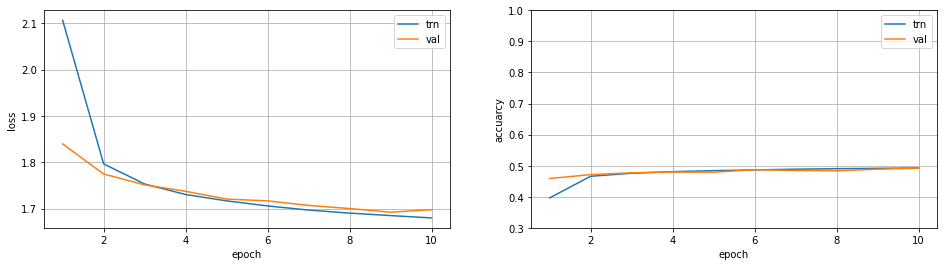

epoch:   20  (trn, val) loss: 1.6551, 1.6717;   acc: 0.4994, 0.4942;   perp:   5.23,  5.32;  9.64s   

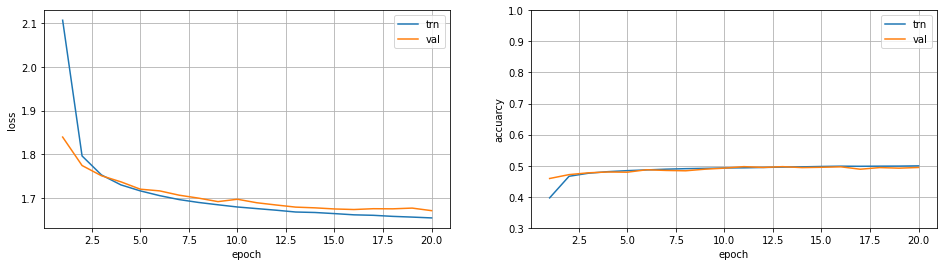

epoch:   30  (trn, val) loss: 1.6443, 1.6583;   acc: 0.5027, 0.4990;   perp:   5.18,  5.25;  9.65s   

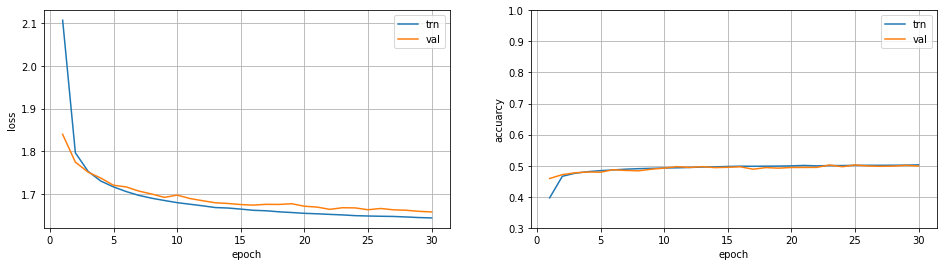

epoch:   40  (trn, val) loss: 1.6370, 1.6523;   acc: 0.5042, 0.4967;   perp:   5.14,  5.22;  9.63s   

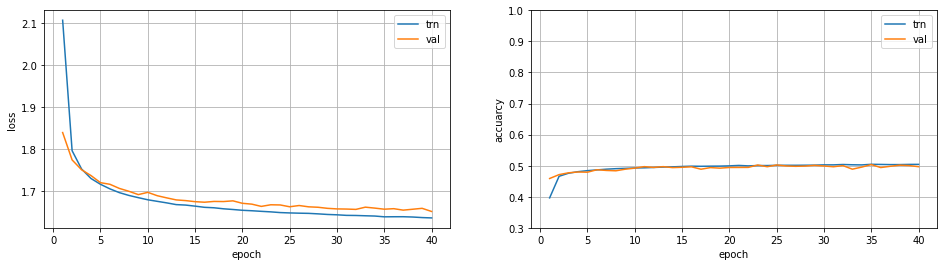

epoch:   50  (trn, val) loss: 1.6317, 1.6531;   acc: 0.5066, 0.5052;   perp:   5.11,  5.22;  9.65s   

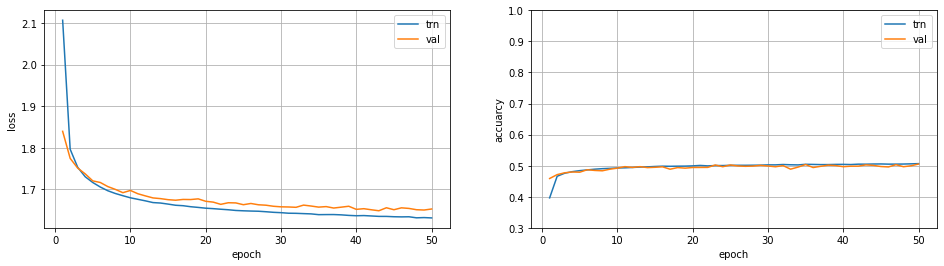

epoch:   60  (trn, val) loss: 1.6281, 1.6442;   acc: 0.5067, 0.5078;   perp:   5.09,  5.18;  9.63s   

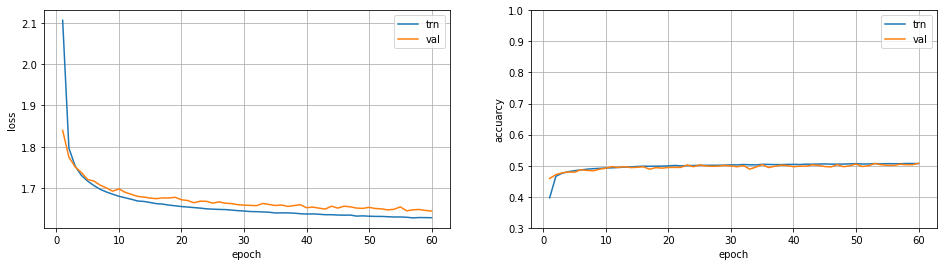

epoch:   70  (trn, val) loss: 1.6251, 1.6430;   acc: 0.5080, 0.4980;   perp:   5.08,  5.17;  9.64s   

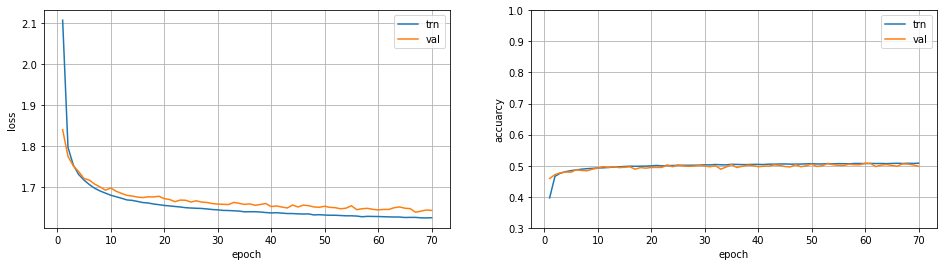

epoch:   80  (trn, val) loss: 1.6234, 1.6409;   acc: 0.5075, 0.5037;   perp:   5.07,  5.16;  9.63s   

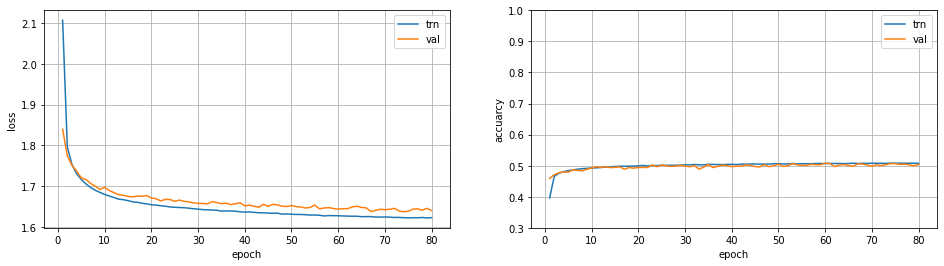

epoch:   90  (trn, val) loss: 1.6206, 1.6397;   acc: 0.5081, 0.5053;   perp:   5.06,  5.15;  9.64s   

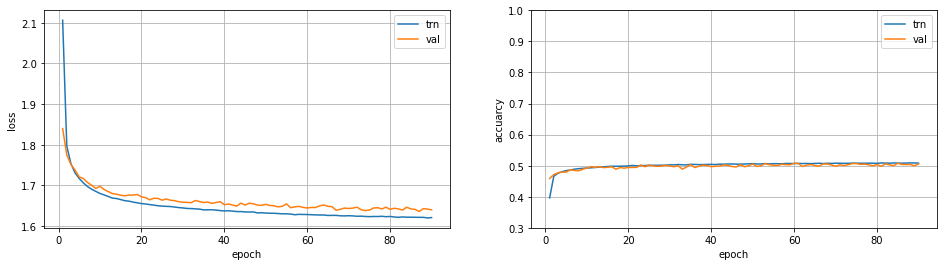

epoch:  100  (trn, val) loss: 1.6175, 1.6354;   acc: 0.5088, 0.5053;   perp:   5.04,  5.13;  9.65s   

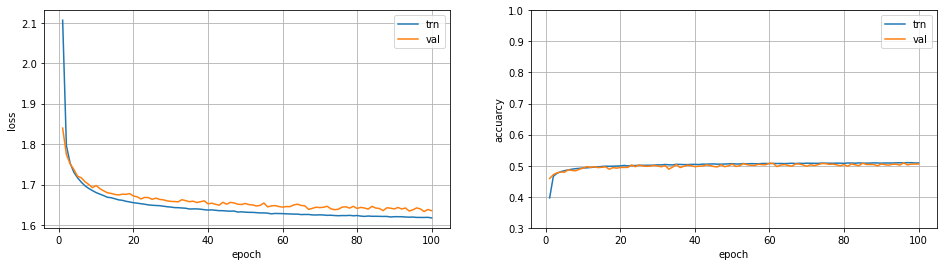

epoch:  110  (trn, val) loss: 1.6162, 1.6365;   acc: 0.5101, 0.5057;   perp:   5.03,  5.14;  9.63s   

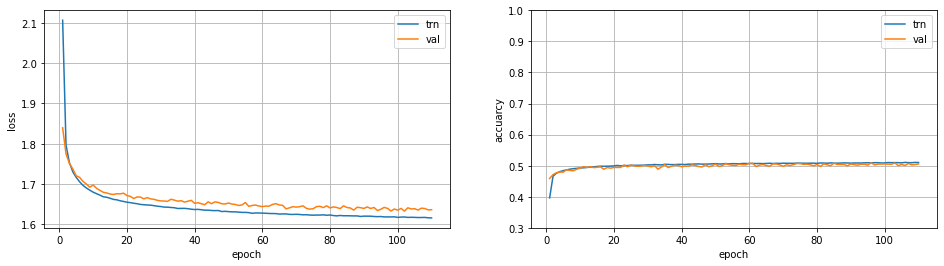

epoch:  120  (trn, val) loss: 1.6145, 1.6376;   acc: 0.5110, 0.5030;   perp:   5.03,  5.14;  9.65s   

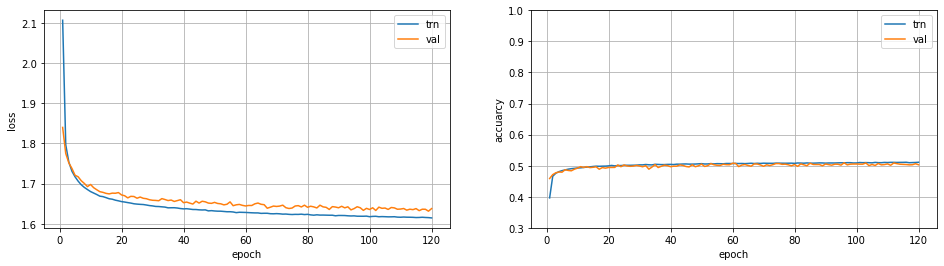

epoch:  130  (trn, val) loss: 1.6142, 1.6375;   acc: 0.5105, 0.5047;   perp:   5.02,  5.14;  9.63s   

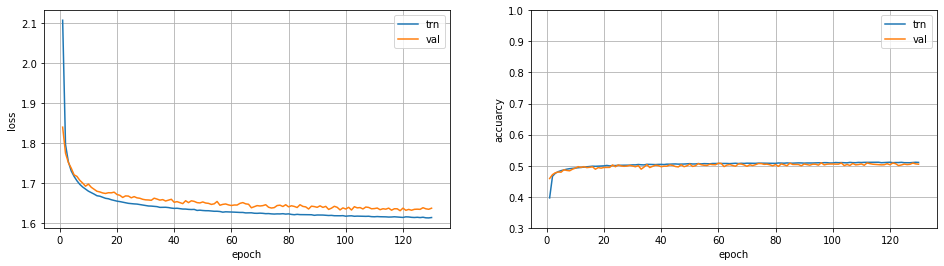

epoch:  140  (trn, val) loss: 1.6133, 1.6346;   acc: 0.5098, 0.5065;   perp:   5.02,  5.13;  9.65s   

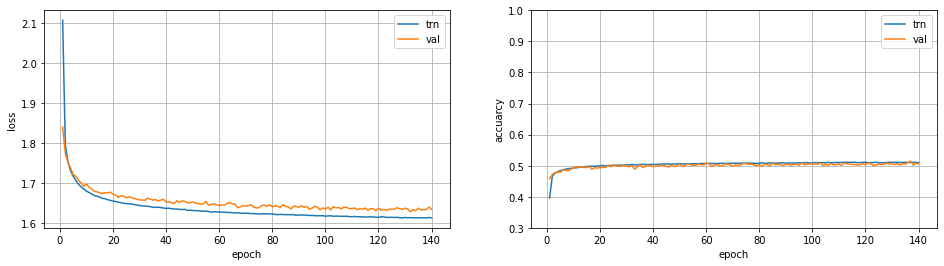

epoch:  150  (trn, val) loss: 1.6115, 1.6294;   acc: 0.5115, 0.5077;   perp:   5.01,  5.10;  9.64s   

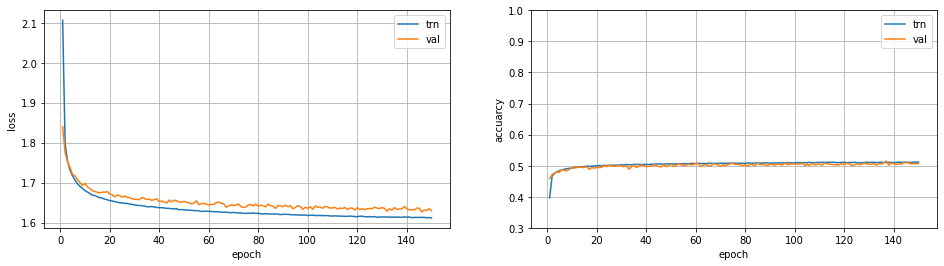

epoch:  160  (trn, val) loss: 1.6113, 1.6303;   acc: 0.5109, 0.5060;   perp:   5.01,  5.11;  9.64s   

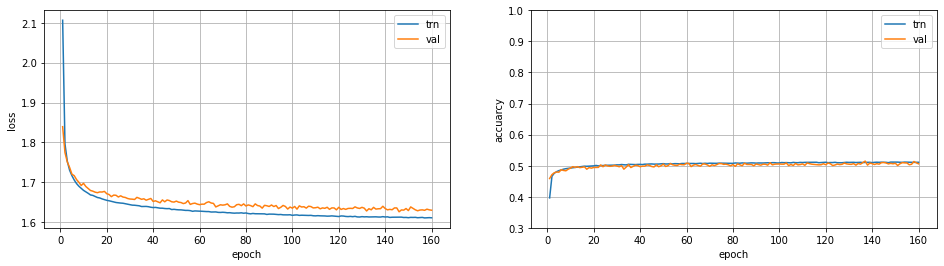

epoch:  170  (trn, val) loss: 1.6105, 1.6367;   acc: 0.5117, 0.5062;   perp:   5.01,  5.14;  9.64s   

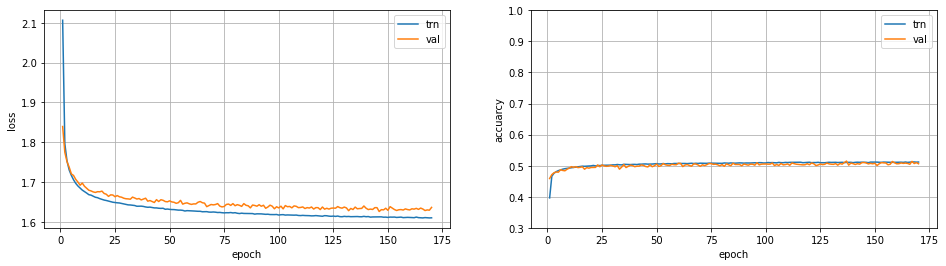

epoch:  180  (trn, val) loss: 1.6089, 1.6343;   acc: 0.5118, 0.5037;   perp:   5.00,  5.13;  9.64s   

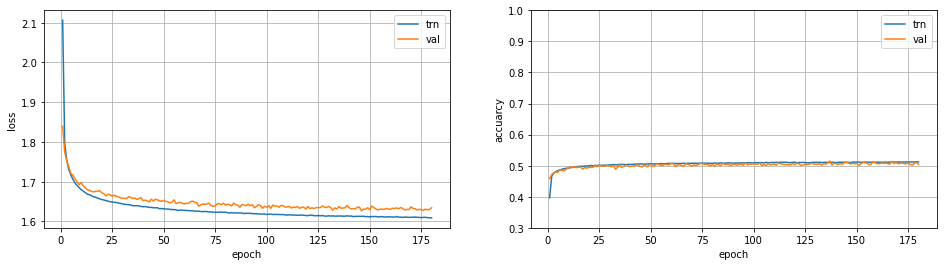

epoch:  190  (trn, val) loss: 1.6084, 1.6353;   acc: 0.5114, 0.5069;   perp:   4.99,  5.13;  9.65s   

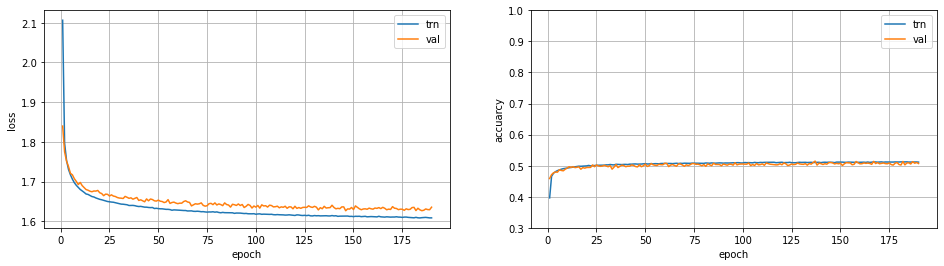

epoch:  200  (trn, val) loss: 1.6082, 1.6298;   acc: 0.5122, 0.5035;   perp:   4.99,  5.10;  9.64s   

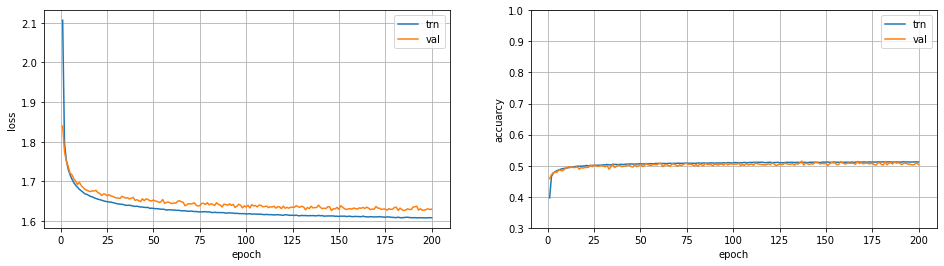

epoch:  210  (trn, val) loss: 1.6072, 1.6287;   acc: 0.5130, 0.5066;   perp:   4.99,  5.10;  9.65s   

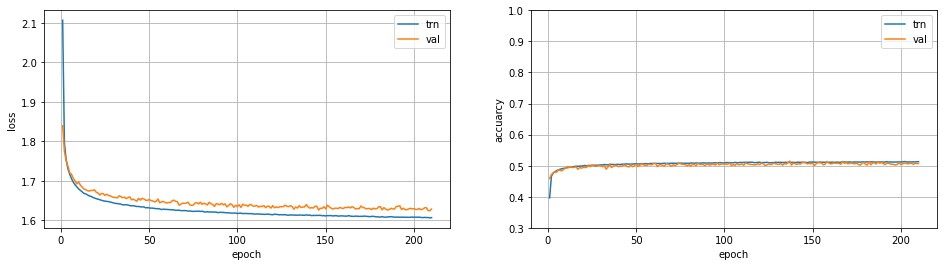

epoch:  220  (trn, val) loss: 1.6062, 1.6266;   acc: 0.5123, 0.5097;   perp:   4.98,  5.09;  9.63s   

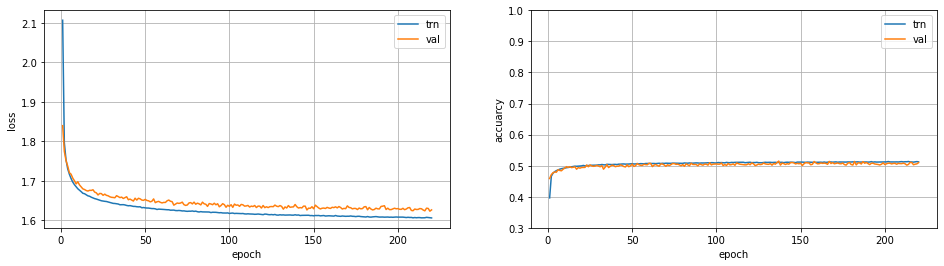

epoch:  230  (trn, val) loss: 1.6071, 1.6274;   acc: 0.5124, 0.5085;   perp:   4.99,  5.09;  9.64s   

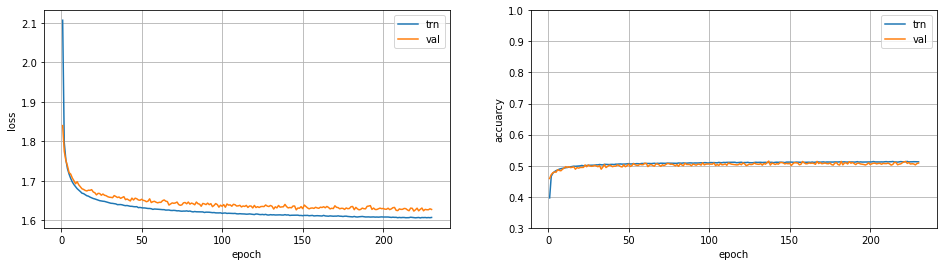

epoch:  240  (trn, val) loss: 1.6054, 1.6250;   acc: 0.5129, 0.5107;   perp:   4.98,  5.08;  9.64s   

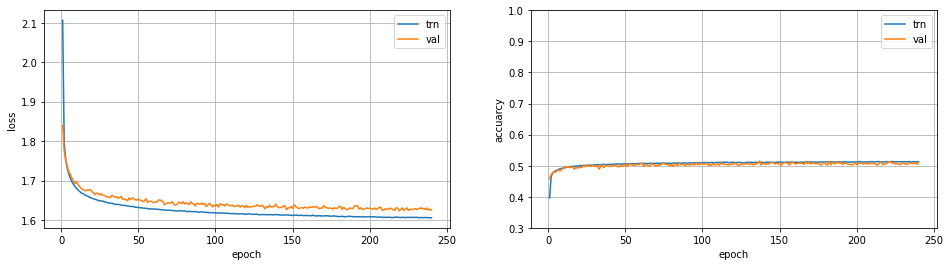

epoch:  250  (trn, val) loss: 1.6053, 1.6273;   acc: 0.5131, 0.5090;   perp:   4.98,  5.09;  9.63s   

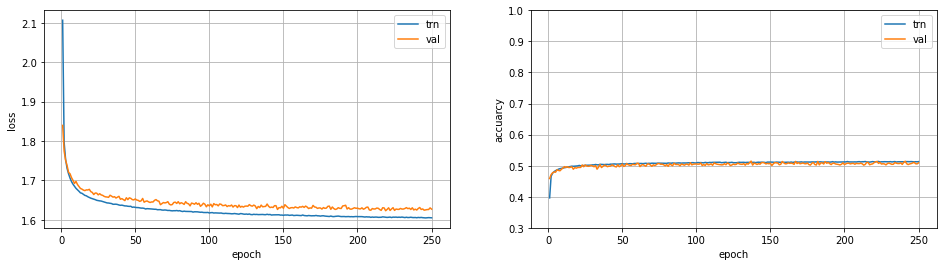

epoch:  260  (trn, val) loss: 1.6044, 1.6313;   acc: 0.5143, 0.5081;   perp:   4.97,  5.11;  9.65s   

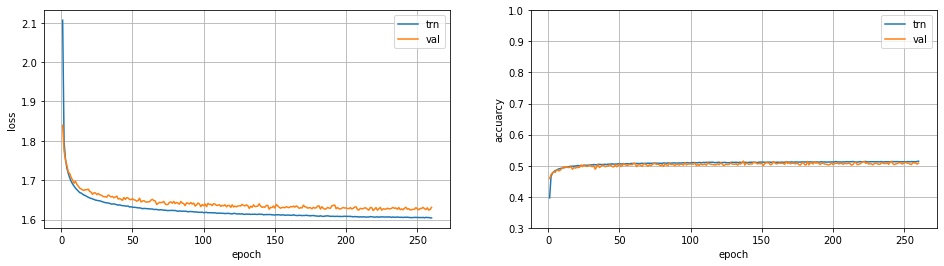

epoch:  270  (trn, val) loss: 1.6052, 1.6270;   acc: 0.5124, 0.5091;   perp:   4.98,  5.09;  9.64s   

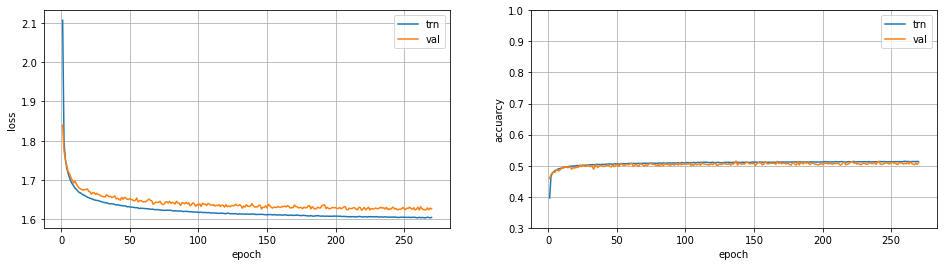

epoch:  280  (trn, val) loss: 1.6040, 1.6251;   acc: 0.5135, 0.5104;   perp:   4.97,  5.08;  9.65s   

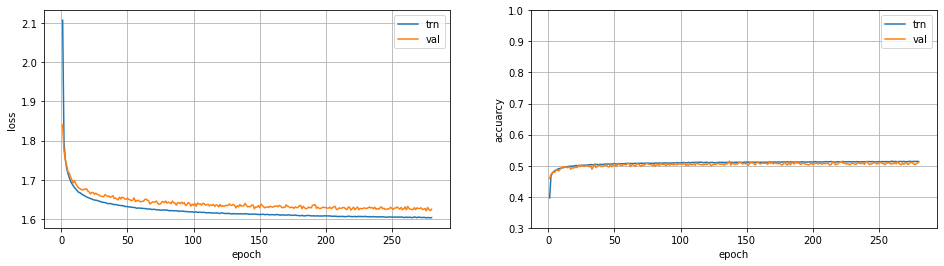

epoch:  290  (trn, val) loss: 1.6035, 1.6269;   acc: 0.5139, 0.5097;   perp:   4.97,  5.09;  9.64s   

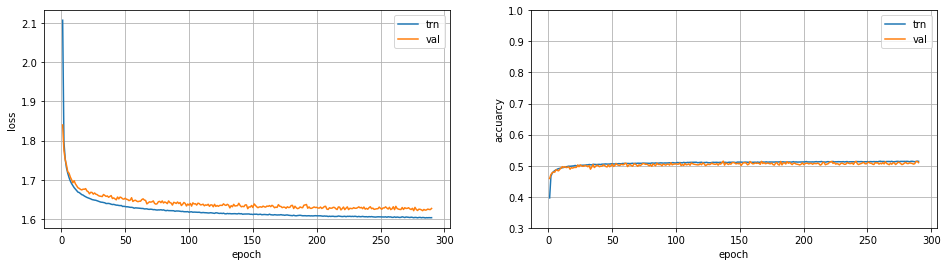

epoch:  300  (trn, val) loss: 1.6029, 1.6226;   acc: 0.5134, 0.5057;   perp:   4.97,  5.07;  9.64s   

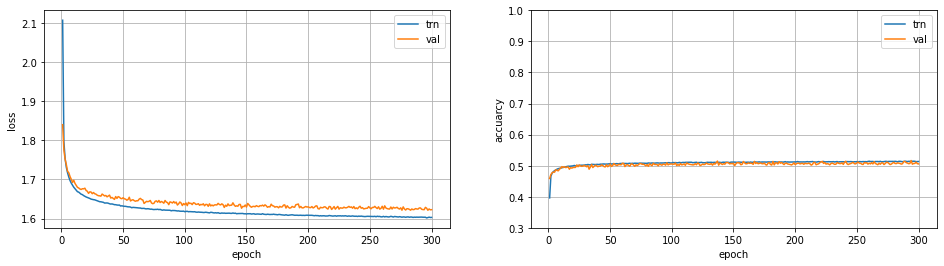

epoch:  310  (trn, val) loss: 1.6027, 1.6224;   acc: 0.5141, 0.5107;   perp:   4.97,  5.07;  9.63s   

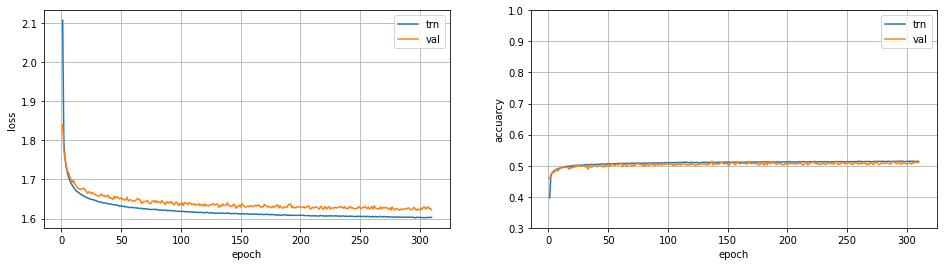

KeyboardInterrupt: ignored

In [9]:
model.rnn.mode = 1
print(CFG.get())
epochs = 1000
while epoch < epochs:                           # эпоха - проход по всем примерам    
    beg = tm()
    
    idx = torch.randperm( len(X_trn) )     
    X_trn, Y_trn = X_trn[idx],  Y_trn[idx]
    
    L_trn, A_trn = fit(model, X_trn, Y_trn, batch_size=CFG.BATCH, NUM = CFG.NUM, train=True )      
    L_val, A_val = fit(model, X_val, Y_val, batch_size=2048, NUM = 1,  train=False) 
    
    history.append([epoch, L_trn, L_val, A_trn, A_val])
                
    if epoch % 1 == 0 or epoch == epochs-1:     
        print(f'\repoch: {epoch:4d}  (trn, val) loss: {L_trn:.4f}, {L_val:.4f};  ',   
              f'acc: {A_trn:.4f}, {A_val:.4f};   perp:  {np.exp(L_trn):5.2f}, {np.exp(L_val):5.2f};  {tm()-beg:.2f}s', end="   " )  
              #f'acc: {A:.4f} {(oks*tot).sum():.4f}  {oks.mean():.4f} {len(oks[oks > 1/len(oks)])/len(oks):.2f}' )  
            
    if epoch % 10 == 0 or epoch == epochs-1:                 
        plot_train(history)
        if model.rnn.mode != 1:        
            plot_grad(model)    

    epoch += 1              

# Результаты
```
LEN:16, STEP:16, NUM:8, E_DIM:10, H_DIM:100, NUM_LAYERS:3, DROP:0.05, BATCH:2048, L2:1e-05, LR:0.01
len(textID):8659364 num:541208, STEP:16
epoch:  252  (trn, val) loss: 1.6197, 1.6550;   acc: 0.5062, 0.5019;   perp:   5.05,  5.23;  7.14s  
```

```
LEN, STEP = 100, 1
E_DIM, H_DIM, NUM_LAYERS, DROP = 10, 100, 1, 0.2
epoch: 19/19  63.26s loss: trn=1.5113 val=1.3357   (last: 1.5091)  perpl:  4.53 acc: 0.5208 0.5208  0.5094 1.00

LEN, STEP = 100, 1
E_DIM, H_DIM, NUM_LAYERS, DROP = 10, 100, 1, 0  GRU
epoch: 19/19  55.01s loss: trn=0.9968 val=0.9993   perpl:  2.71   acc: trn=0.7358 val=0.7358
epoch: 52/125 55.95s loss: trn=0.1353 val=0.1353   perpl:  1.14   acc: trn=0.9743 val=0.9743

LEN, STEP = 100, 1 
E_DIM, H_DIM, NUM_LAYERS, DROP = 10, 100, 1, 0  LSTM
epoch: 21/21  56.09s loss: trn=1.2782 val=1.2694   perpl:  3.59   acc: trn=0.6559 val=0.6559
epoch: 40/62  57.16s loss: trn=0.4476 val=0.4318   perpl:  1.56   acc: trn=0.8810 val=0.8810
epoch: 63/126 57.46s loss: trn=0.1022 val=0.0880   perpl:  1.11   acc: trn=0.9828 val=0.9828

LEN, STEP = 100, 1 
E_DIM, H_DIM, NUM_LAYERS, DROP = 10, 100, 1, 0  GRU NUM = 90
epoch: 25/25  35.94s loss: trn=0.6280 val=0.5689   perpl:  1.87   acc: trn=0.8474 val=0.8474
epoch: 32/58  37.74s loss: trn=0.2546 val=0.1764   perpl:  1.29   acc: trn=0.9609 val=0.9609
epoch: 70/129 37.24s loss: trn=0.0953 val=0.0427   perpl:  1.10   acc: trn=0.9934 val=0.9934
epoch: 0/156  37.74s loss: trn=0.0746 val=0.0319   perpl:  1.08   acc: trn=0.9947 val=0.9956

```


# Генерация текста

In [ ]:
import numpy as np

st = "три девицы под окном пряли поздно вечерко"
#st = "кабы я была"
#st = "говорит одна"
#st = "то на весь крещ"
#st = "уложили спать"

model.rnn.mode = 1
def random_char(probs):        
    return np.random.choice(len(probs), 1, p=probs)[0]

x = torch.tensor( [ charID[ st[0] ]  ], dtype=torch.long).view(1,1)
h = torch.zeros (CFG.NUM_LAYERS, 1, CFG.H_DIM) 
for i in range(1000):
    y, h = model(x, h0 = h.detach(), NUM=1)                   # (B,C,1), (LAYERS,B,H)  
    probs = nn.Softmax(dim=1)(y.detach()[:,:,-1])
    probs = probs.cpu().numpy().reshape(-1)    
    idx = charID[ st[i] ] if i < len(st) else random_char(probs)         
    x[0,0]  = torch.tensor(idx, dtype=torch.long, device=device) 
    print(CHARS[idx], end="")            

# Cохранение модели

In [ ]:
import datetime
  
state = {'info':      "RNN генератор текста по буквам",   
         'date':      datetime.datetime.now(),            
         'parms':     "",            
         'model' :    model.state_dict(),                 
         'optimizer': optimizer.state_dict()}             
 
torch.save(state, 'rnn_char_100_10_100_1_loss_0_xx.pt')                          

In [ ]:
state = torch.load('rnn_char_100_10_100_1_loss_0_xx.pt')                   # загружаем файл
 
model.load_state_dict(state['model'])        # получаем параметры модели

# Tests

In [ ]:
tm1 = tm()

y = torch.empty(100,256,256)        
for i in range(100):
    x = torch.randn(256,256, 
                    requires_grad=True)
    y[i] = x
    
y.retain_grad()   
z = y.sum()
z.backward()
    
print(tm()-tm1   )
print(y.grad_fn, y.grad.shape)

In [ ]:
tm1 = tm()

y = []       
for i in range(100):
    x = torch.randn(1,256,256, requires_grad=True)
    y.append( x )        
y = torch.cat(y, dim=0)

#x.retain_grad()   
z = y.sum()
z.backward()
  
print(tm()-tm1)
print(y.grad_fn)

In [ ]:
import torchviz
from torch import tensor, empty, ones, zeros

x, w, b = ones(5), ones(5, requires_grad=True), tensor(0., requires_grad=True)
z = x.dot(w) + b

torchviz.make_dot(z,  params = {'x': x, 'w': w, 'b': b} )

In [ ]:
idx = torch.tensor([1,0,2,0])
torch.zeros(len(idx),3).scatter_(1, idx.unsqueeze(1), 1.)

In [ ]:
L, C = 3, 4

inp = torch.tensor([ [1,0,1],  [0,2,3] ], dtype=torch.long)
one_hot = torch.zeros(len(inp), L, C).scatter_(2, inp.unsqueeze(2),  1.)
print(one_hot)